## Prova d'esame 

Anno scolastico 2020-2021, Chignoli

**Descrizione del progetto**

Analisi dataset molluschi gasteropodi https://archive.ics.uci.edu/ml/datasets/Abalone. Attraverso un analisi e una costruzione di uno o più modelli, dati i parametri di facile misurazione (quali dimensioni e peso) ricavo e prevedo il numero di anelli del gasteropode. Dal sito relativo al dataset vi è riportato che per il calcolo dell'età del mollusco è sufficiente sommare $1.5$ al numero di anelli. Perciò mi limiterò a classificare in base al numero di anelli. 
Inizialmente ho utilizzato il numero di anelli per un analisi di regressione. Successivamente ho creato $5$ fasce, in base al numero di anelli, in cui classificare i dati.

**Nota** il dataset non è uniformemente distribuito sulle classi definite. In prima analisi utilizzo tutti i dati del dataset per la costruzione di un modello in grado di classificare, in secondo luogo, creò un dataset uniformemente distribuito sulla variabile di target e alleno il modello con questo dataset.

Importo le librerie necessarie.

In [514]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

## 1. Importo e riorganizzo il dataset

In [515]:
df=pd.read_csv("abalone.data",header=None)

In [516]:
df.columns=["sesso","lunghezza","diametro","altezza","peso tot","peso interno","peso interno asciutto","peso guscio","anelli"]

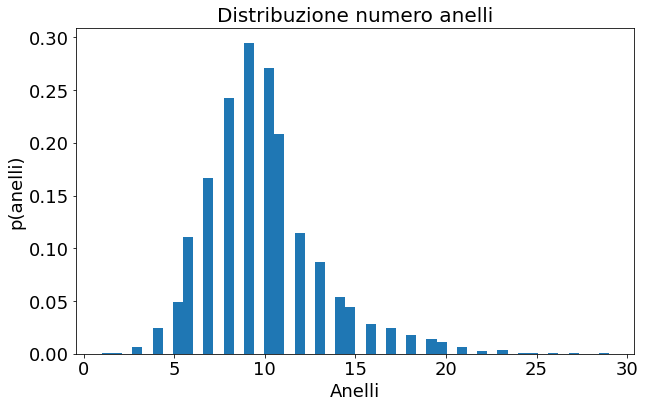

In [517]:
plt.rcParams.update({'font.size': 18})
f1=plt.figure(figsize=(10,6))
plt.hist(df["anelli"],bins=50,density=True)
plt.title("Distribuzione numero anelli",fontsize=20)
plt.xlabel("Anelli",fontsize=18)
plt.ylabel("p(anelli)",fontsize=18)
plt.show()

**Descrizione figura 1** Si osserva la distribuzione del numero di anelli. Non è una variabile distribuita uniformemente. Si potrebbero effettuare alcuni fit su distribuzioni note per osservarne la compatibilità. 

In [518]:
train=df.sample(frac=0.8,random_state=200) 
test=df.drop(train.index)

In [519]:
yt=train["anelli"]
xt=train.drop(["anelli","sesso"],axis=1)
ytt=test["anelli"]
xtt=test.drop(["anelli","sesso"],axis=1)

In [520]:
reg = LinearRegression().fit(xt, yt)

In [521]:
an_pred=reg.predict(xtt)
int_an=an_pred.astype(int)

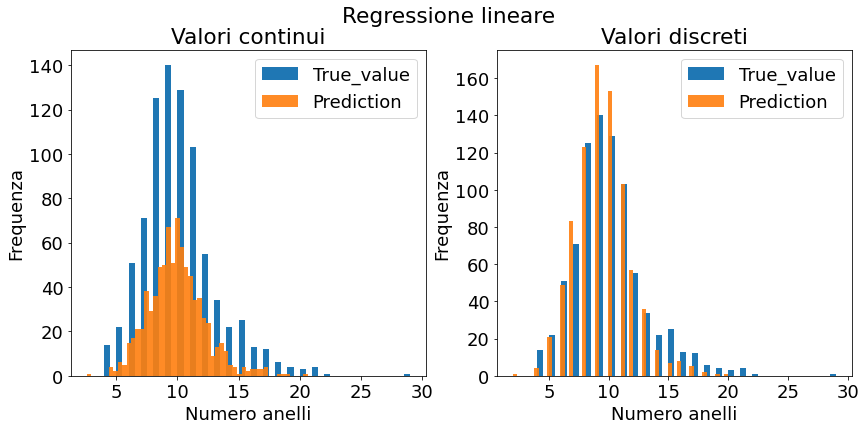

In [522]:
fig=plt.figure(figsize=(14,6))
fig.suptitle('Regressione lineare')
plt.subplot(1, 2, 1)
plt.title("Valori continui")
plt.hist(ytt,bins=50,label="True_value")
plt.hist(an_pred,bins=50,alpha=0.9,label="Prediction")
plt.xlabel("Numero anelli")
plt.ylabel("Frequenza")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Valori discreti")
plt.hist(ytt,bins=50,label="True_value")
plt.hist(int_an,bins=50,alpha=0.9,label="Prediction")
plt.xlabel("Numero anelli")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

**Descrizione figura 2** Per ottenere il secondo grafico è stata presa la parte intera dei dati relativi alla predizione da regressione lineare.

Il modello dela regressione lineare è un primo approccio per osservare se vi è correlazione lineare tra la variabile $X$ e $Y$.

Nonostante l'apparente andamento simile nei grafici tra la predizione e i dati reali lo score dei dati di test è relativamente basso:

In [523]:
print("test score: " +str(reg.score(xtt,ytt)))
print("training score: "+str(reg.score(xt,yt)))

test score: 0.4867208282666369
training score: 0.5361288641322032




**Suddivido in fasce in base al numero di anelli**

In [524]:
df["anelli"].max(),df["anelli"].min()

(29, 1)

Il numero di anelli va da un minimo di $1$ ad un massimo di $29$. Ho provato ad utilizzare per la classificazione le $29$ classi ognuna relativa al numero corrispondente di anelli. Questo approccio non porta a risultati apprezzabili con i metodi utilizzati, per via del numero troppo elevato di classi. Perciò ho raggruppato in $5$ classi le $29$ classi iniziali.

Classe $1$: da $1$ a $6$ anelli,

Classe $2$: da $7$ a $12$ anelli,

Classe $3$: da $13$ a $18$ anelli,

Classe $4$: da $19$ a $24$ anelli,

Classe $5$: da $25$ a $29$ anelli.

Ho inoltre traformato in valore numerico la variabile sesso, per osservarne la correlazione.

In [525]:
df.head()
df.loc[df["sesso"]=="M","sex"]=1
df.loc[df["sesso"]=="F","sex"]=2
df.loc[df["sesso"]=="I","sex"]=3
df["sesso"]=df["sex"]
df=df.drop("sex",axis=1)
df.loc[df["anelli"]<=6,"categoria"]=1
df.loc[(df["anelli"]<=12) & (df["anelli"]>6),"categoria"]=2
df.loc[(df["anelli"]<=18) & (df["anelli"]>12),"categoria"]=3
df.loc[(df["anelli"]<=24) & (df["anelli"]>18),"categoria"]=4
df.loc[(df["anelli"]<=30) & (df["anelli"]>24),"categoria"]=5
df=df.drop("anelli",axis=1)

In [526]:
df.head(5)

,sesso,lunghezza,diametro,altezza,peso tot,peso interno,peso interno asciutto,peso guscio,categoria
0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,3.0
1,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,2.0
2,2.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2.0
3,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,2.0
4,3.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,2.0


**Commento sul dataset** Ho riorganizzato il dataset, eliminando se presenti le righe con alcuni valori non tabulati, e creando la variabile categoria. I dati con valori continui sono riscalati di un fattore $200$ come specifica la fonte del dataset, perciò ometterò l'unità di misura.

Oltre a questo dataset da cui cercherò di estrapolare un metodo di calssificazione, creo un nuovo dataset che possiede la variabile categoria uniforme, ed elimino l'ultima classe perchè ha un numero troppo ridotto di dati.

In [527]:
n_class=89
df_unif1 = df.loc[(df.categoria==1)]
df_unif2 = df.loc[(df.categoria==2)]
df_unif3 = df.loc[(df.categoria==3)]
df_unif4 = df.loc[(df.categoria==4)]
elim=df_unif1["sesso"].count()-n_class
df_unif1 = df_unif1[:-elim]
elim=df_unif2["sesso"].count()-n_class
df_unif2 = df_unif2[:-elim]
elim=df_unif3["sesso"].count()-n_class
df_unif3 = df_unif3[:-elim]

In [528]:
df_unif=df_unif1.append(df_unif2)
df_unif=df_unif.append(df_unif3)
df_unif=df_unif.append(df_unif4)

A questo punto il dataframe $df_{unif}$ contiene dati distribuiti uniformemente secondo la variabile $categoria$, e senza la categoria numero $5$. 

## 2. Matrice di correlazione

Date $N$ variabili $X_i$ si definisce in primo luogo la matrice di covarianza $N\times N$ come:

$$C_{ij}=Cov(X_i,X_j).$$

Dove $Cov(X_i,X_j)=\langle X_i X_j \rangle- \langle X_i \rangle \langle X_j \rangle$, e $Cov(X_i,X_i)=Var(X_i)$.

Successivamente si definisce la matrice di correlazione come:
$$K_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}.$$
Vale la relazione $\vert K_{ij} \vert \leq 1$.

La matrice di correlazione quantifica la correlazione delle variabili.

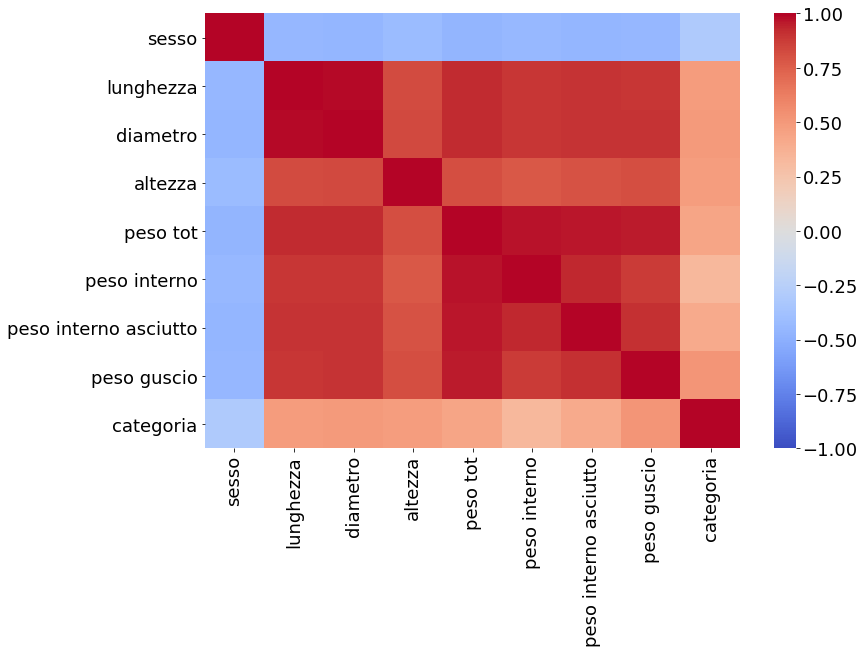

In [529]:
f2=plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),vmin=-1,vmax=+1,cmap="coolwarm")
plt.show()

**Descrizione figura 3** Dalla matrice di correlazione si osserva come quasi tutte le quantità hanno una correlazione importante, ciò è dovuto banalmente al fatto che all'aumentare del peso del mollusco vi è un aumento delle dimensioni del mollusco e anche del numero di anelli. Le categorie e gli anelli sono correlate proprio per la definizione data delle categorie che corrispondono appunto alle fasce d'età, invece la piccola correlazione inversa tra sesso e gli altri parametri è dovuta alla definizione di sesso come $M=1,F=2,I=3$. Infatti all'aumentare di questo valore si ha una diminuzione degli altri parametri, come è facilmente intuibile.

## 3. PCA

L'analisi PCA permette di proiettare i dati sulle direzioni con maggior varianza e quindi permette di descivere i dati con meno variabili senza perdere troppa informazione.
Definita la matrice di design con $N$ campionamenti e $P$ caratteristiche:

$$X \in R^{N\times P},$$

si centra la media in zero e si normalizzano le distribuzioni:

$$y_{np}=\frac{x_{np}-\bar{x}_{p}}{\sigma_p},$$

dove $\bar{x}_{p}=\frac{1}{N}\sum_{n}x_{np}$ e $\sigma_{p}^2=\frac{1}{N-1}\sum_{n}(x_{np}-\bar{x}_{p})^2$.

Valgono $\langle y_{np} \rangle=0$ e $\langle \Delta y_{np}^2 \rangle=1$.

La matrice di covarianza è data da:

$$C=\frac{1}{N-1}Y^{T}Y.$$

Effettuo ora la trasformazione del cambiamento di base:

$$D=V^{T}CV,$$

con $D=diag(\lambda_1,\lambda_2, ... \lambda_P).$

Gli autovettori della matrice corrispondono alle varianze, seleziono le $p<P$ varianze maggiori per descrivere i miei dati senza perdere troppo in informazione, e avendo il vantaggio di avere ridotto le dimensioni iniziali.

Infine selezionate le $p$ componenti, e definita la matrice $\bar{V} \in R^{P\times p}$, le coordinate della traformazione sono date da:

$$Z^{PCA}=X\bar{V}$$




Provo ad effettuare la PCA  sul mio dataset per vedere se riesco a categorizzare i dati.

## 3.1. PCA per i dati di train

In [530]:
train=df.sample(frac=0.8,random_state=200) 
test=df.drop(train.index)

Ho tolto la colonna anelli dai dataset di train e test, dato che classifico in base a categorie di età.

In [531]:
train.describe()

,sesso,lunghezza,diametro,altezza,peso tot,peso interno,peso interno asciutto,peso guscio,categoria
count,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000
mean,1.950329,0.524146,0.408018,0.139584,0.830884,0.360484,0.180717,0.239243,2.087373
std,0.829304,0.120848,0.099797,0.042675,0.494842,0.224220,0.110114,0.140381,0.590883
min,1.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,1.000000,0.450000,0.345000,0.115000,0.438000,0.184000,0.092000,0.130000,2.000000
50%,2.000000,0.545000,0.425000,0.140000,0.801750,0.335500,0.171000,0.232750,2.000000
75%,3.000000,0.615000,0.480000,0.165000,1.160125,0.500875,0.251875,0.330000,2.000000
max,3.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,5.000000


In [532]:
test.describe()

,sesso,lunghezza,diametro,altezza,peso tot,peso interno,peso interno asciutto,peso guscio,categoria
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,1.976048,0.523377,0.407335,0.139246,0.820168,0.354898,0.180099,0.237181,2.062275
std,0.822000,0.117092,0.097033,0.038267,0.472337,0.212760,0.107656,0.134453,0.550519
min,1.000000,0.140000,0.105000,0.000000,0.014500,0.005000,0.002500,0.005000,1.000000
25%,1.000000,0.455000,0.350000,0.115000,0.463000,0.191250,0.097500,0.135000,2.000000
50%,2.000000,0.540000,0.425000,0.145000,0.795500,0.337500,0.170000,0.235000,2.000000
75%,3.000000,0.610000,0.480000,0.165000,1.141000,0.504250,0.256000,0.319750,2.000000
max,3.000000,0.760000,0.605000,0.240000,2.381000,1.081500,0.522500,0.725000,5.000000


In [533]:
scaler = StandardScaler()

In [534]:
Ytrain=train["categoria"]
Xtrain = train.drop(["categoria","sesso"],axis=1)
Xtrain_trans = scaler.fit_transform(Xtrain)

In [535]:
dfxtrain = pd.DataFrame(data=Xtrain_trans,columns=["lunghezza","diametro","altezza","peso tot","peso int","peso int asc","peso guscio"])

In [536]:
pca = PCA(n_components=None)
df_pca = pca.fit(dfxtrain)
df_pca.explained_variance_ratio_

array([9.05133626e-01, 4.23905388e-02, 2.45110793e-02, 1.60876426e-02,
       9.12423778e-03, 1.86714931e-03, 8.85726107e-04])

Con le due prime componenti principali ho circa l' $94\%$ dell'informazione contenuta nel dataset.

In [537]:
dfx_train_trans = pca.transform(dfxtrain)
dfx_train_trans = pd.DataFrame(data=dfx_train_trans)
dfx_train_trans.describe()

,0,1,2,3,4,5,6
count,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03
mean,2.471592e-17,2.782202e-18,-5.648285e-17,1.259050e-17,-1.090872e-17,-2.362795e-18,-1.892728e-17
std,2.517505e+00,5.448143e-01,4.142812e-01,3.356296e-01,2.527623e-01,1.143414e-01,7.875239e-02
min,-6.361824e+00,-2.269706e+00,-1.363964e+00,-3.362951e+00,-1.178324e+00,-7.891021e-01,-8.950556e-01
25%,-1.874858e+00,-2.220679e-01,-2.634385e-01,-1.201099e-01,-1.156110e-01,-6.199710e-02,-1.580666e-02
50%,7.431180e-02,-3.830324e-03,-6.511645e-02,1.307650e-02,3.543219e-03,-4.197003e-05,2.462149e-03
75%,1.792533e+00,2.224247e-01,1.642526e-01,1.683859e-01,1.183956e-01,6.258023e-02,2.849032e-02
max,8.679352e+00,2.086418e+01,6.649023e+00,3.706867e+00,1.573002e+00,1.728691e+00,9.486587e-01


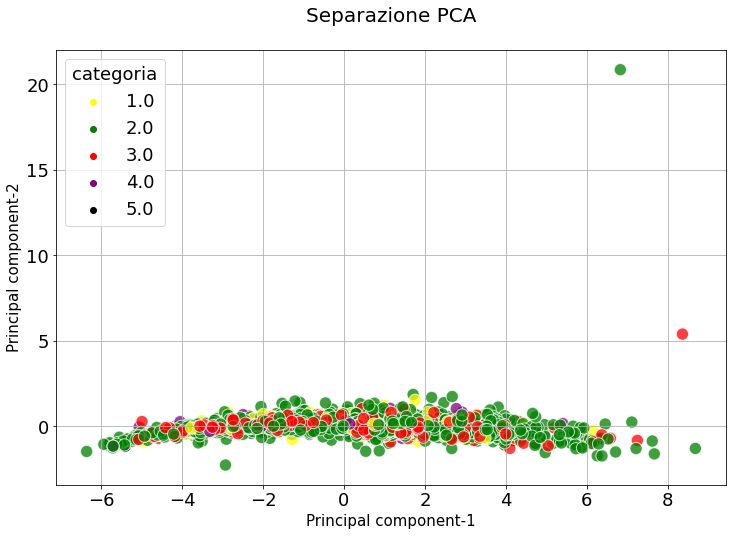

In [538]:
f3=plt.figure(figsize=(12,8))
sns.scatterplot(x=dfx_train_trans[0],y=dfx_train_trans[1],hue=train["categoria"],alpha=0.75,s=150,palette=["yellow","green","red","purple","black"])
plt.grid(True)
plt.title("Separazione PCA\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

**Descrizione figura 4** L'analisi PCA non permette una scomposizione in classi definite del dataset.

## 3.2. PCA per i dati categorizzati uniformemente

Uso il metodo della PCA anche per il dataframe con distribuzione uniforme per categoria, per vedere se riesco a categorizzare i dati. Non effetuo una suddivisione dei dati come per test e train come nel caso precedente.

In [539]:
Yunif=df_unif["categoria"]
Xunif = df_unif.drop(["categoria","sesso"],axis=1)
Xunif_trans = scaler.fit_transform(Xunif)

In [540]:
dfxunif = pd.DataFrame(data=Xunif_trans,columns=["lunghezza","diametro","altezza","peso tot","peso int","peso int asc","peso guscio"])

In [541]:
pca = PCA(n_components=None)
df_pca = pca.fit(dfxunif)
df_pca.explained_variance_ratio_

array([9.34699302e-01, 2.99771201e-02, 1.67035799e-02, 1.12772101e-02,
       5.56326483e-03, 9.06135501e-04, 8.73388018e-04])

In [542]:
dfx_unif_trans = pca.transform(dfxunif)
dfx_unif_trans = pd.DataFrame(data=dfx_unif_trans)
dfx_unif_trans.describe()

,0,1,2,3,4,5,6
count,3.560000e+02,3.560000e+02,3.560000e+02,3.560000e+02,3.560000e+02,3.560000e+02,3.560000e+02
mean,-1.871162e-17,4.888412e-17,1.793197e-17,8.576161e-18,-5.445862e-17,7.073384e-17,3.255043e-17
std,2.561509e+00,4.587275e-01,3.424243e-01,2.813589e-01,1.976172e-01,7.975472e-02,7.830031e-02
min,-5.046075e+00,-1.013277e+00,-1.280517e+00,-9.667468e-01,-7.144245e-01,-3.275215e-01,-2.579617e-01
25%,-2.283054e+00,-3.124082e-01,-1.566387e-01,-1.629839e-01,-8.980362e-02,-4.528432e-02,-4.116998e-02
50%,3.477989e-01,-1.262242e-01,-6.247992e-03,2.788566e-03,1.012566e-03,-7.658903e-04,-5.209550e-03
75%,1.786281e+00,2.248216e-01,1.253011e-01,1.891419e-01,8.639412e-02,3.564048e-02,3.682235e-02
max,6.524791e+00,2.202770e+00,1.643890e+00,1.201862e+00,7.854975e-01,4.181753e-01,3.474840e-01


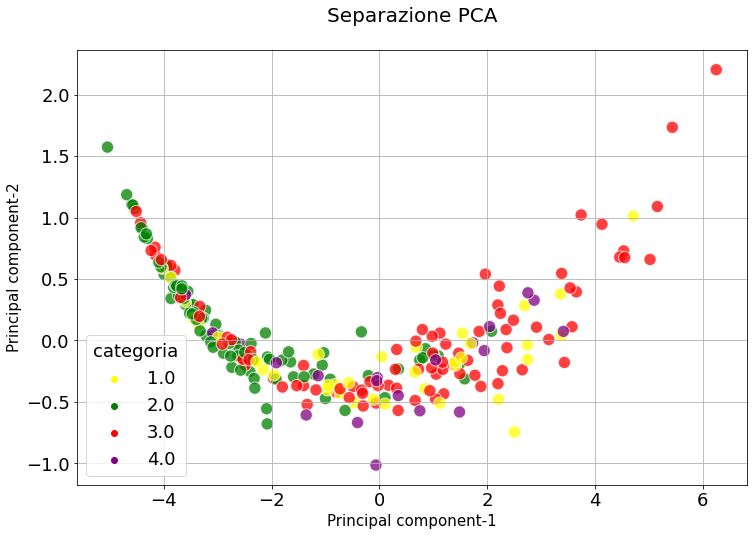

In [543]:
f4=plt.figure(figsize=(12,8))
sns.scatterplot(x=dfx_unif_trans[0],y=dfx_unif_trans[1],hue=df_unif["categoria"],alpha=0.75,s=150,palette=["yellow","green","red","purple"])
plt.grid(True)
plt.title("Separazione PCA\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

**Descrizione figura 5** Attraverso l'analisi PCA del dataset riorganizzato uniformemente, si osserva una maggior clusterizzazione delle varie classi, anche se come risultato non è ancora soddisfacente.

## 4. K-nearest neighbour

Provo ad utilizzare i dati di test, per osservare se con la tecnica dei primi vicini riesco a categorizzare correttamente i dati dopo le dovuto trasformazioni PCA. 

**Posso effettuarlo:**

**1.** da dati iniziali (ciò può dare problemi perchè sono in 7 dimensioni),


**2.** dopo la trasformazione PCA utilizzando solo le due componenti principali.

## 4.1. K-nearest neighbour: dati iniziali 7 dimensioni

In [544]:
Ytest=test["categoria"]
Xtest= test.drop(["categoria","sesso"],axis=1)
score=[]

for i in range(1,50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(Xtrain, Ytrain)
    score.append(neigh.score(Xtest,Ytest))

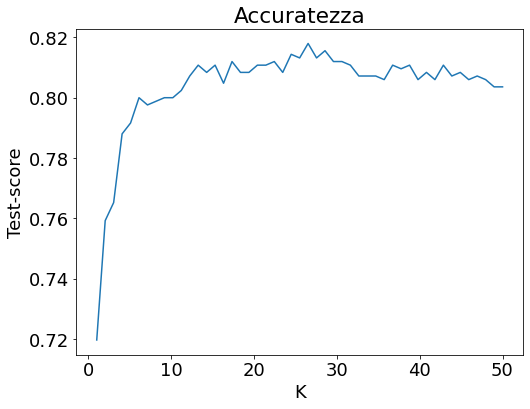

In [545]:
f5=plt.figure(figsize=(8,6))
x=np.linspace(1,50,49)
plt.plot(x,score)
plt.title("Accuratezza")
plt.xlabel("K")
plt.ylabel("Test-score")
plt.show()

**Descrizione figura 6** Per valori di $K$ maggiori di $15$ non si ha un miglioramento del modello. L'accuratezza massima raggiunta da questo modello è circa $82\%$. Risultato non soddisfacente, perchè il dataset iniziale ha la maggior parte dei dati appartenenti alla classe numero $2$, perciò ci si aspetta un errore relativamente basso di previsione utilizzando questo metodo.

## 4.2. K-nearest neighbour: dopo PCA in due dimensioni

Proietto le variabili di test nelle componenti della PCA.

In [546]:
scaler = StandardScaler()
Xtest_t = scaler.fit_transform(Xtest)

In [547]:
dfxt = pd.DataFrame(data=Xtest_t)

In [548]:
dfx_test_trans = pca.transform(dfxt)
dfx_test_trans = pd.DataFrame(data=dfx_test_trans)
dfx_test_trans.describe()

,0,1,2,3,4,5,6
count,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02
mean,-1.511765e-16,-1.215927e-16,-3.018543e-16,1.148117e-16,-1.703395e-16,-1.009869e-16,1.961172e-17
std,2.541147e+00,4.473720e-01,3.666485e-01,3.415091e-01,2.799840e-01,1.004717e-01,1.061994e-01
min,-6.061449e+00,-1.265320e+00,-1.746507e+00,-1.429423e+00,-1.316796e+00,-4.841115e-01,-5.811231e-01
25%,-1.760153e+00,-3.081385e-01,-1.905611e-01,-1.885766e-01,-1.409320e-01,-4.817535e-02,-5.251661e-02
50%,1.364800e-01,-8.937078e-02,-2.528025e-02,1.594446e-02,1.295453e-02,-3.505045e-03,5.690514e-04
75%,1.801572e+00,2.120381e-01,1.365052e-01,2.066080e-01,1.313380e-01,4.996301e-02,4.926352e-02
max,6.402764e+00,2.128132e+00,2.215220e+00,2.614336e+00,1.145992e+00,5.785058e-01,7.768301e-01


In [549]:
Xpcatrain=pd.DataFrame([dfx_train_trans[0],dfx_train_trans[1]])
Xpcatest=pd.DataFrame([dfx_test_trans[0],dfx_test_trans[1]])
Xpcatest1=pd.DataFrame(Xpcatest.T)

In [550]:
score=[]
for i in range(1,40):
    neighpca = KNeighborsClassifier(n_neighbors=i)
    neighpca.fit(Xpcatrain.T,Ytrain)
    score.append(neighpca.score(Xpcatest1,Ytest))

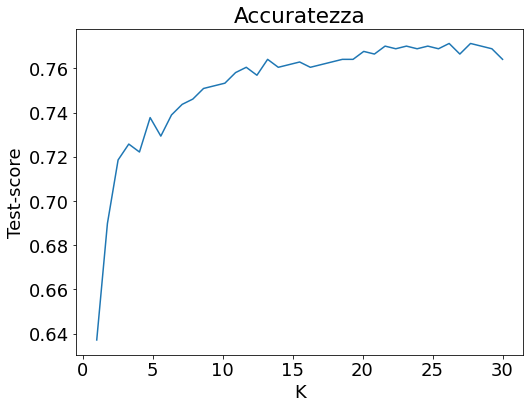

In [551]:
f6=plt.figure(figsize=(8,6))
x=np.linspace(1,30,39)
plt.plot(x,score)
plt.title("Accuratezza")
plt.xlabel("K")
plt.ylabel("Test-score")
plt.show()

**Descrizione figura 7** L'analisi dei primi vicini nel caso dell'analisi con le prime due componenti della PCA,fornisce un accuratezza massima di circa $77\%$, risultato peggiore rispetto al caso senza PCA, questo risultato non è ancora apprezzabile, dato che l'analisi della PCA, non ha permesso una suddivisione dei dati nelle varie classi. 

## 4.3. K-nearest neighbour: da dati uniformi 7 dimensioni

In [552]:
trainunif=df_unif.sample(frac=0.8,random_state=200) 
testunif=df_unif.drop(trainunif.index)

In [553]:
Ytrainunif=trainunif["categoria"]
Xtrainunif = trainunif.drop(["categoria","sesso"],axis=1)

In [554]:
Ytestunif=testunif["categoria"]
Xtestunif= testunif.drop(["categoria","sesso"],axis=1)

In [555]:
score=[]
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(Xtrainunif, Ytrainunif)
    score.append(neigh.score(Xtestunif,Ytestunif))

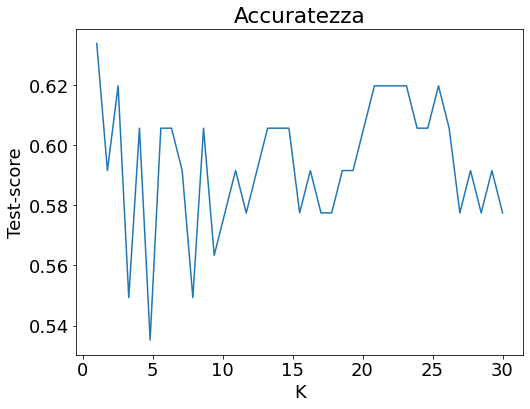

In [556]:
f7=plt.figure(figsize=(8,6))
x=np.linspace(1,30,39)
plt.plot(x,score)
plt.title("Accuratezza")
plt.xlabel("K")
plt.ylabel("Test-score")
plt.show()

**Descrizione figura 8** L'analisi dei primi vicini utilizzando un dataset di train uniformemente distribuito fornisce una accuratezza dall'andamento caotico. Ciò è dovuto al poco numero di dati a disposizione nel dataset (perchè è stato ridotto per renderlo uniforme), e inoltre ai troppi parametri utilizzati $p=7$.

Trovandoci di fronte a un dataset con $7$ caratteristiche il metodo dei primi vicini non fornisce risultati soddisfacenti. Per questo motivo ho provato un approccio di classficazione attraverso le reti neurali.

## 5. Rete neurale per classificazione

Mantengo la suddivisione precedentemente effettuata tra dati di train e dati di test.

In [557]:
print("Numero dati di training: " + str(len(Xtrain)))
print("Numero dati di test: " + str(len(Xtest)))

Numero dati di training: 3342
Numero dati di test: 835


Stampo le dimensioni delle varie componenti del dataset:

In [558]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((3342, 7), (3342,), (835, 7), (835,))

Trasformo in array i dataset pandas:

In [559]:
X_train=Xtrain.values
Y_train=Ytrain.values
X_test=Xtest.values
Y_test=Ytest.values

Converto i dati in Y in interi:

In [560]:
Y_train=Y_train.astype(int)
Y_test=Y_test.astype(int)

## 5.1. Rete neurale con Scikit-learn

Imposto i parametri da passare alla rete neurale.

In [561]:
n_hidden_neurons = 20
eta_vals = np.logspace(-8, 1, 10)
lmbd_vals = np.logspace(-8, 1, 10)
epochs = 100
eta = 0.001
lmbd = 0.001

In [562]:
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn

In [563]:
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
best_value=[0,0]
best=0
for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)
        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)
        if(test_accuracy[i][j]>best):
            best=test_accuracy[i][j]
            best_value[0]=eta_vals[i]
            best_value[1]=lmbd_vals[j]

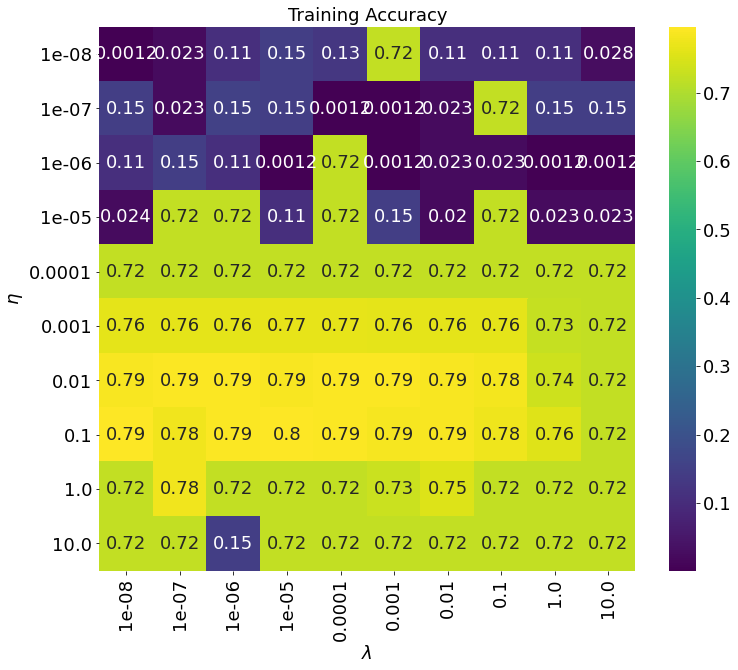

In [564]:
f8= plt.figure(figsize = (12, 10))
sns.heatmap(train_accuracy, annot=True, cmap="viridis",xticklabels=eta_vals, yticklabels=lmbd_vals)
plt.title("Training Accuracy",fontsize=18)
plt.ylabel("$\eta$")
plt.xlabel("$\lambda$")
plt.show()

**Descrizione figura 9** Si osserva che i migliori si ottengono per learning rate tra $0.01$ e $0.1$ e per un ampio range di valori del parametro di regolarizzazione.

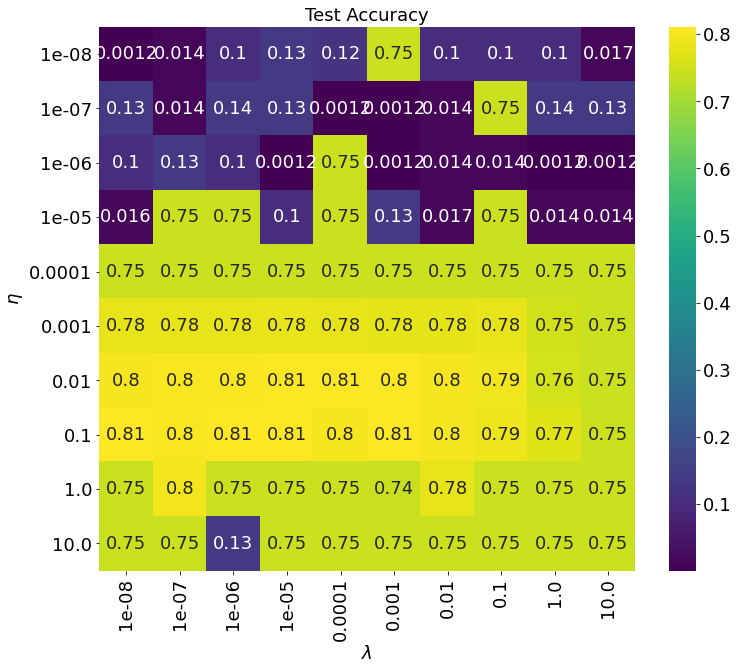

In [565]:
f9 = plt.figure(figsize = (12, 10))
sns.heatmap(test_accuracy, annot=True, cmap="viridis",xticklabels=eta_vals, yticklabels=lmbd_vals)
plt.title("Test Accuracy",fontsize=18)
plt.ylabel("$\eta$")
plt.xlabel("$\lambda$")
plt.show()

**Descrizione figura 10** Scelti i parametri migliori ottengo un'accuratezza di test di circa $81\%$.

Seleziono i parametri migliori.

In [566]:
eta=best_value[0]
lmbd=best_value[1]

dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs,solver="adam",batch_size=32)
dnn.fit(X_train, Y_train)

MLPClassifier(activation='logistic', alpha=1e-06, batch_size=32,
              hidden_layer_sizes=20, learning_rate_init=0.1, max_iter=100)

In [567]:
prev=dnn.predict(X_test)

In [568]:
count=0
for i in range(0,len(X_test)):
    if(prev[i]==Y_test[i]):
        count=count+1

In [569]:
count/len(X_test)

0.792814371257485

**Descrizione risultato** Si riesce a raggiungere un'acccuratezza massima dell' $80\%$, non è un risultato ottimo, ma è comunque decisamente migliore di una classificazione random $20\%$.

In [570]:
cm = confusion_matrix(Y_test, prev)
print(cm)

[[ 49  37   1   0   0]
 [ 15 545  63   0   0]
 [  0  44  68   0   0]
 [  0   1  11   0   0]
 [  0   0   1   0   0]]


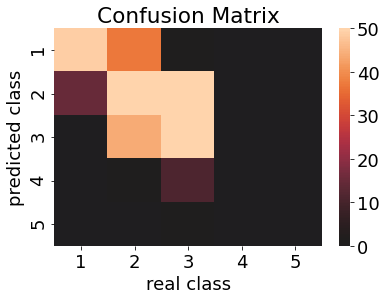

In [571]:
sns.heatmap(cm, center=True, vmin=0, vmax=50,xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title("Confusion Matrix")
plt.ylabel("predicted class")
plt.xlabel("real class")
plt.show()

## 5.2. Uso dati di training uniformi

In [572]:
X_trainunif=Xtrainunif.values
Y_trainunif=Ytrainunif.values
X_testunif=Xtestunif.values
Y_testunif=Ytestunif.values

In [573]:
Y_trainunif=Y_trainunif.astype(int)
Y_testunif=Y_testunif.astype(int)

In [574]:
n_hidden_neurons = 30
eta_vals = np.logspace(-8, 1, 10)
lmbd_vals = np.logspace(-8, 1, 10)
epochs = 100
eta = 0.001
lmbd = 0.001

In [575]:
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_trainunif, Y_trainunif)
        DNN_scikit[i][j] = dnn

In [576]:
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
best_value=[0,0]
best=0
for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_scikit[i][j]
        train_pred = dnn.predict(X_trainunif) 
        test_pred = dnn.predict(X_testunif)
        train_accuracy[i][j] = accuracy_score(Y_trainunif, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_testunif, test_pred)
        if(test_accuracy[i][j]>best):
            best=test_accuracy[i][j]
            best_value[0]=eta_vals[i]
            best_value[1]=lmbd_vals[j]

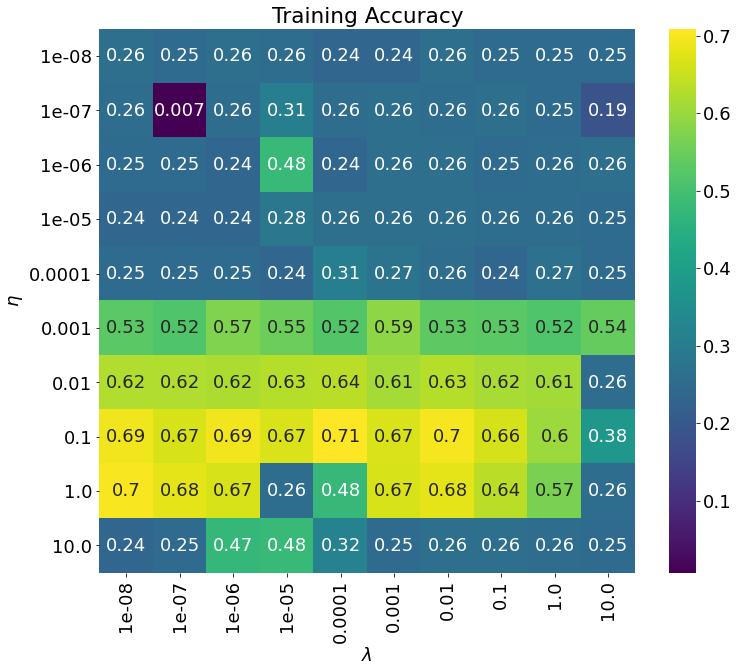

In [577]:
f10= plt.figure(figsize = (12, 10))
sns.heatmap(train_accuracy, annot=True, cmap="viridis",xticklabels=eta_vals, yticklabels=lmbd_vals)
plt.title("Training Accuracy")
plt.ylabel("$\eta$")
plt.xlabel("$\lambda$")
plt.show()

**Descrizione figura 10** Nel training con dati uniformi, anche per i parametri che mi forniscono l'accuratezza migliore, non ho risultati soddisfacenti. Questo è dovuto al fatto che sto considerando un dataset molto ristretto di valori.

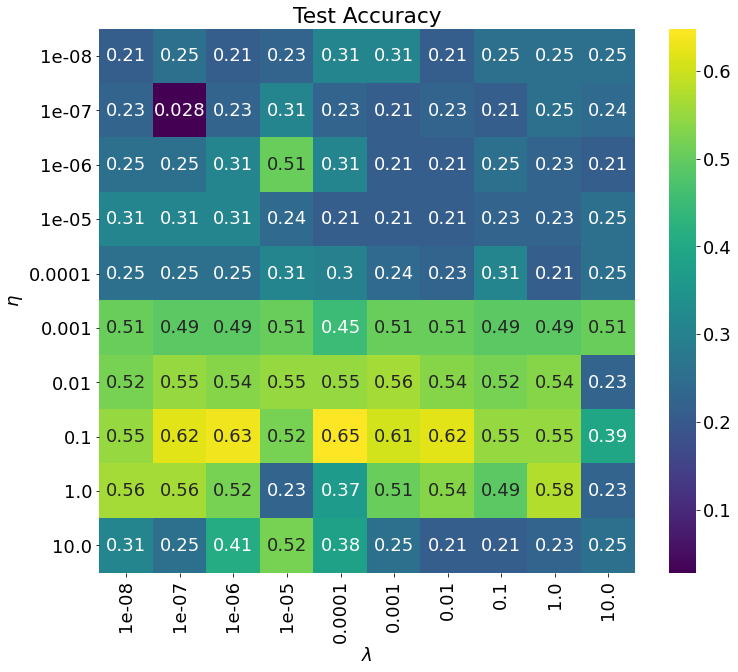

In [578]:
f11 = plt.figure(figsize = (12, 10))
sns.heatmap(test_accuracy, annot=True, cmap="viridis",xticklabels=eta_vals, yticklabels=lmbd_vals)
plt.title("Test Accuracy")
plt.ylabel("$\eta$")
plt.xlabel("$\lambda$")
plt.show()

**Descrizione figura 11** Come nel caso di training l'accuratezza non è soddisfacente, per il limitato numero di dati utilizzati nel training.

## 6. Regressione logistica

Provo ad efferruare la classificazione con la regressione logistica per $K=5$ classi.

$$ \log \left (\frac{P(G=1\vert X=\underline{x})}{P(G=K\vert X=\underline{x})}\right )=\beta_{10}+\underline{\beta}_{1}^{T}\underline{x}$$

$$ \log \left (\frac{P(G=2\vert X=\underline{x})}{P(G=K\vert X=\underline{x})}\right )=\beta_{20}+\underline{\beta}_{2}^{T}\underline{x}$$

$$...$$

$$...$$

La relazione è lineare dopo l'applicazione del logaritmo.
Si ottengono perciò:

$$P(G=1\vert X=\underline{x})=\frac{\exp(\beta_{10}+\underline{\beta}_{1}^{T}\underline{x})}{1+\sum_l^{K-1}\exp(\beta_{l0}+\underline{\beta}_l^{T}\underline{x})}$$

$$...$$

$$...$$

$$P(G=K\vert X=\underline{x})=\frac{1}{1+\sum_l^{K-1}\exp(\beta_{l0}+\underline{\beta}_l^{T}\underline{x})}$$

Per fittare la regressione logistica si può usare il metodo di massima verosimiglianza:

$$P(D\vert \underline{\beta})=\prod[p_i^{y_i}(\underline{\beta})(1-p_i(\underline{\beta}))^{y_i}],$$

$$\hat{\beta}=argmax(P(D\vert \underline{\beta}))$$

Si trova un risultato analogo minimizzando la funzione di costo.



In [579]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [580]:
Y_pred=clf.predict(X_test)

In [581]:
print("ACCURACY: "+str(accuracy_score(Y_test, Y_pred)))

ACCURACY: 0.7952095808383234


Ho provato a valutare l'accuratezza utilizzando il metodo $K$-fold cross validation, con diversi valori di $K$, ma i risultati ottenuti risultano analoghi.

## 7. Support vector machine

In [582]:
clf1 = svm.SVC()
clf1.fit(X_train, Y_train)

SVC()

In [583]:
Y_pred=clf1.predict(X_test)

In [584]:
print("ACCURACY: "+str(accuracy_score(Y_test, Y_pred)))

ACCURACY: 0.7964071856287425


Ho provato a valutare l'accuratezza utilizzando il metodo $K$-fold cross validation, con diversi valori di $K$, ma i risultati ottenuti risultano analoghi.

## Conclusioni

Dal dataset selezionato, mi ero posto l'obbiettivo di classificare in $5$ classi di età dei molluschi. Tale dataset però, contiene caratteristiche che non riescono a dividere accuratamente nelle varie classi con i metodi utilizzati. Il miglior risultato si ottiene con le reti neurali con un'errore sui dati di test del $20\%$ circa. Avrei potuto utilizzare altri metodi come random forest, SVM kernel, adaboost... e aumentare il range dei parametri utilizzati. Probabilmente con modelli più sofisticati e avanzati si sarebbe riuscito ad ottenere un'accuratezza di test migliore.